In [1]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import (
    Input,
    Dense,
)

#config = tf.ConfigProto()
#config.gpu_options.allow_growth = True
#sess = tf.Session(config=config)
from tensorflow.compat.v1 import InteractiveSession

config = tf.compat.v1.ConfigProto()
#config.gpu_options.allow_growth = True
#session = InteractiveSession(config=config)
config.gpu_options.per_process_gpu_memory_fraction = 0.7
tf.compat.v1.keras.backend.set_session(
    tf.compat.v1.Session(config=config))
  

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn import preprocessing
import glob
import cv2
import numpy as np

import gc
from time import time
import logging

from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split

In [3]:
from tf_explain.core.activations import ExtractActivations
from tf_explain.core.gradients_inputs import GradientsInputs
from tf_explain.core.vanilla_gradients import VanillaGradients
from tf_explain.core.integrated_gradients import IntegratedGradients
from tf_explain.core.occlusion_sensitivity import OcclusionSensitivity
from tf_explain.core.smoothgrad import SmoothGrad
from tf_explain.core.grad_cam import GradCAM

In [4]:

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.cluster import KMeans

# Load CSV

In [2]:
!pwd

/home/koolaid/Documents/ML/data_from_HangyuanGuo


### make_df function

In [3]:
def make_df (filename):
    df = pd.read_csv(filename, header=None)
    
    #To normalize the values (scale them between 0,1)
    x = df.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df = pd.DataFrame(x_scaled)
    
    #label all the columns with headers
    df.columns = ['I','II','III','aVL','aVR','aVF','V1','V2','V3','V4','V5','V6']
    
    #Because I want to a reduced dataset (I only want I,II,V2,V5)
    df = df.drop(columns=['III','aVL','aVR','aVF','V1','V3','V4','V6'])
    
    return df

### Test block for make_df function

In [4]:
dir_path = 'ECGDataDenoised/'
file_name = 'MUSE_20180111_155115_19000.csv'

filename = os.path.join(dir_path,file_name)
signal = make_df(filename)
signal

,I,II,V2,V5
0,0.437732,0.067429,0.929980,0.265193
1,0.467199,0.097830,0.936099,0.297798
2,0.495614,0.126982,0.942150,0.328996
3,0.521787,0.153501,0.948195,0.357443
4,0.544361,0.176110,0.954450,0.381956
...,...,...,...,...
4995,0.387227,0.631779,0.783662,0.552917
4996,0.410146,0.649671,0.783791,0.569527
4997,0.426192,0.661665,0.785156,0.582669
4998,0.437470,0.669058,0.786902,0.593239


# Plot the signal

### create_plot function

In [4]:
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

def create_plot(data1, i, store_path, file_name):
    
    #plt.figure()
    
    #fig,lead=plt.subplots(12,1, figsize=(20,60)) #### ORIGINAL - FOR ALL 12 LEADS
    #fig,lead=plt.subplots(4,1, figsize=(10,20), dpi = 100) ### Version 1
    fig,lead=plt.subplots(4,1, figsize=(10,10), dpi = 50) ### Version 2

    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0) #deals with all the whitespace around the plots


    lead[0].plot(data1['I'],'white')
    lead[0].set_axis_off()
    #lead[0].cmap=plt.cm.binary
    lead[1].plot(data1['II'],'white')
    lead[1].set_axis_off()

    lead[2].plot(data1['V2'],'white')
    lead[2].set_axis_off()
    
    lead[3].plot(data1['V5'],'white')
    lead[3].set_axis_off()

    
    #file_name = 'img%d.png' %(i) #this is for testing
    #fig.tight_layout()
    #plt.show()
    
    file_name = file_name.replace('.csv','.png')
    
    fig.savefig(os.path.join(store_path,file_name), facecolor ='black', transparent = None, bbox_inches = 'tight', pad_inches = 0)
    plt.close()

### test block to test the function 'create_plot'

In [6]:
store_path = "temp_delete"
os.makedirs(store_path, exist_ok=True)

i = 0
j = 2

test_1 = create_plot(signal, j, store_path)

# Append images into an array

In [25]:
X_data = []
files = sorted(glob.glob('temp_delete/img2.png')) #change temp_outputs to your storage area for images created
for myFile in files:
    print(myFile)
    #read the image
    image = cv2.imread(myFile,0)
    
    #normalize the image
    #norm_image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)#, dtype=cv2.CV_32F)
    
    #threshold the image
    #ret,thresh1 = cv2.threshold(image,0.01,1,cv2.THRESH_BINARY)
    #th3 = cv2.adaptiveThreshold(norm_image,1,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
    ret, otsu = cv2.threshold(image,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    X_data.append(otsu)

train_im = np.asarray(X_data, dtype= 'uint8')

temp_delete/img2.png


### Confirm the properties of the training images array

In [33]:
train_im.shape

(1, 500, 500)

### Revisualizing the modifications made to the image

In [44]:
from PIL import Image

img = Image.fromarray(train_im[0], 'L')
img.show()

un = np.unique(train_im)
un

array([  0, 255], dtype=uint8)

# Automating steps 1-3 for all ECGDenoised Signals

In [14]:
store_path = "ECGDenoisedImages"
os.makedirs(store_path, exist_ok=True)

#i = 0 # only used if loop breaks early by accident

files = sorted(glob.glob('ECGDataDenoised/*.csv')) #parsing through the files
#files = sorted(glob.glob('ECGDataDenoised/*.csv'), reverse = True) #parsing through the files if other loop breaks early
for myFile in files:    
    #print(myFile)
    
    #Step 1: Loading CSV
    signal = make_df(myFile)
    file_name = myFile.split('/')[1]

    #Step 2: Making an image    
    create_plot(signal, 1, store_path, file_name)
    
    # only use this block if the loop breaks before finishing (run remainder files)
    # also have to add reverse = True to the files = sorted()
    #i += 1
    #if i == 257:
    #    print('Done!')
    #    break
    
print('Done!')

Done!
Done!


In [22]:
#Step 3: Converting to an array
t1 = time()
i = 0
X_data = []
files = sorted(glob.glob('ECGDenoisedImages/*.png')) #change temp_outputs to your storage area for images created
for myFile in files:
    #print(myFile)
    
    #read the image
    image = cv2.imread(myFile,0)
    
    #normalize the image
    #norm_image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)#, dtype=cv2.CV_32F)
    
    #threshold the image
    #ret,thresh1 = cv2.threshold(image,0.01,1,cv2.THRESH_BINARY)
    #th3 = cv2.adaptiveThreshold(norm_image,1,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
    ret, otsu = cv2.threshold(image,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    X_data.append(otsu)

    i += 1
    if i == 5323:
        print('halfway!')
        continue
        
train_im = np.asarray(X_data, dtype= 'uint8')
print (train_im.shape)

#saving the array as a .npy array so if the kernel crashes, you don't lose your work
np.save('data_v1.npy', train_im)
del train_im, X_data
gc.collect()

t2 = time()
print('Loading data in {} seconds.'.format(round(t2-t1)))   

halfway!
(10646, 500, 500)
Loading data in 27 seconds.


# Making label Array

In [24]:
!pwd

/home/koolaid/Documents/ML/data_from_HangyuanGuo


In [61]:
labelfile = 'consolidatedlabels.csv'
df = pd.read_csv(labelfile)
df

,FileName,Rhythm,Label
0,MUSE_20180111_155115_19000,ST,GSVT
1,MUSE_20180111_155154_74000,AFIB,AFIB
2,MUSE_20180111_155203_15000,AFIB,AFIB
3,MUSE_20180111_155249_70000,ST,GSVT
4,MUSE_20180111_155542_84000,AF,AFIB
...,...,...,...
10641,MUSE_20181222_204306_99000,SVT,GSVT
10642,MUSE_20181222_204309_22000,SVT,GSVT
10643,MUSE_20181222_204310_31000,SVT,GSVT
10644,MUSE_20181222_204312_58000,SVT,GSVT


In [62]:
#Because I want to a reduced dataset (I only want I,II,V2,V5)
test = df.drop(columns=['FileName','Rhythm'])
test

,Label
0,GSVT
1,AFIB
2,AFIB
3,GSVT
4,AFIB
...,...
10641,GSVT
10642,GSVT
10643,GSVT
10644,GSVT


In [63]:
# Finding the unique values in label class

y = pd.get_dummies(test.Label, prefix='Label')
print(y.head())

   Label_AFIB  Label_GSVT  Label_SB  Label_SR
0           0           1         0         0
1           1           0         0         0
2           1           0         0         0
3           0           1         0         0
4           1           0         0         0


In [64]:
# Binarizer method of sorting labels
y = LabelBinarizer().fit_transform(df.Label)
y.dtype

dtype('int64')

In [65]:
# OneHot encoded method of sorting labels into an array
y = OneHotEncoder().fit_transform(test).toarray()
type(y)
print(y.shape)
y

(10646, 4)


array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]])

In [75]:
np.save('label_v1.npy', y)
del test, y
gc.collect()

120

# Splitting Data

In [13]:
X = np.load('data_v1.npy')
y = np.load('label_v1.npy')

### Broadcast X into 3 channels to fit with the input setup

In [14]:
X = np.repeat(X.reshape(-1, 500, 500, 1), 3, axis=3)
print('X_train.shape:', X.shape)

X_train.shape: (10646, 500, 500, 3)


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1234)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.11, random_state=1234) # 0.25 x 0.8 = 0.2

In [16]:
print('Training data')
print('X_train.shape:', X_train.shape)
print('y_train.shape:', y_train.shape)
print('X_train.type:', type(X_train))
print('y_train type:', type(y_train))
print('\n')
print('Validation data')
print('X_val.shape:', X_val.shape)
print('y_val.shape:', y_val.shape)
print('\n')
print('Testing data')
print('X_test.shape:', X_test.shape)
print('y_test.shape:', y_test.shape)

del X, y
gc.collect()


Training data
X_train.shape: (8527, 500, 500, 3)
y_train.shape: (8527, 4)
X_train.type: <class 'numpy.ndarray'>
y_train type: <class 'numpy.ndarray'>


Validation data
X_val.shape: (1054, 500, 500, 3)
y_val.shape: (1054, 4)


Testing data
X_test.shape: (1065, 500, 500, 3)
y_test.shape: (1065, 4)


1011

# Creating the Model

### Building the model - Part 1: Base Model

In [17]:
base_model = keras.applications.VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    include_top=False,
    #input_shape=(500, 500, 1),
    input_tensor=Input(shape=(500, 500, 3)))
    

In [18]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 500, 500, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 500, 500, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 500, 500, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 250, 250, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 250, 250, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 250, 250, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 125, 125, 128)     0     

In [19]:
base_model.trainable = False

### Building the trainable part of the model

In [20]:
inputs = keras.Input(shape=(500, 500, 3))
# Separately from setting trainable on the model, we set training to False 
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(4)(x)
model = keras.Model(inputs, outputs)

In [21]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 500, 500, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 15, 15, 512)       14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 2052      
Total params: 14,716,740
Trainable params: 2,052
Non-trainable params: 14,714,688
_________________________________________________________________


In [22]:
# Important to use categorical crossentropy and accuracy as we now have a non binary classification problem
model.compile(loss=keras.losses.CategoricalCrossentropy(), metrics=[keras.metrics.CategoricalAccuracy()])

### Creating the Data Generator (to pass the batches in)

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.0,  # Randomly zoom image
    width_shift_range=0.0,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.0,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images horizontally
    vertical_flip=False, # Don't randomly flip images vertically
)  

In [24]:
batch_size = 4
img_iter = datagen.flow(X_train, y_train, batch_size=batch_size)

In [ ]:
#datagen.fit(X_train)

In [25]:
model.fit(img_iter,
          epochs=5,
          steps_per_epoch=len(X_train)/batch_size, # Run same number of steps we would if we were not using a generator.
          validation_data=(X_val, y_val))

Epoch 1/5
2131/2131 [==============================] - 127s 57ms/step - loss: 8.7045 - categorical_accuracy: 0.3544 - val_loss: 10.2917 - val_categorical_accuracy: 0.3880
Epoch 2/5
2131/2131 [==============================] - 99s 46ms/step - loss: 10.6564 - categorical_accuracy: 0.3850 - val_loss: 10.2917 - val_categorical_accuracy: 0.3880
Epoch 3/5
2131/2131 [==============================] - 98s 46ms/step - loss: 10.7691 - categorical_accuracy: 0.3765 - val_loss: 10.2917 - val_categorical_accuracy: 0.3880
Epoch 4/5
2131/2131 [==============================] - 99s 46ms/step - loss: 10.7108 - categorical_accuracy: 0.3792 - val_loss: 10.2917 - val_categorical_accuracy: 0.3880
Epoch 5/5
2131/2131 [==============================] - 98s 46ms/step - loss: 10.5827 - categorical_accuracy: 0.3797 - val_loss: 10.2917 - val_categorical_accuracy: 0.3880


In [26]:
model.save('pretrainedVGG16_model_v2')

INFO:tensorflow:Assets written to: pretrainedVGG16_model_v2/assets


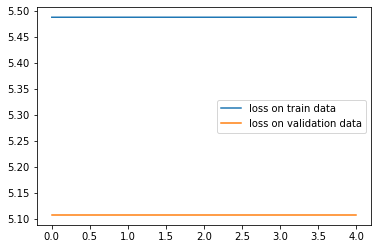

In [25]:
plt.plot(model.history['loss'])
plt.plot(model.history['val_loss'])
plt.legend(['loss on train data', 'loss on validation data'])

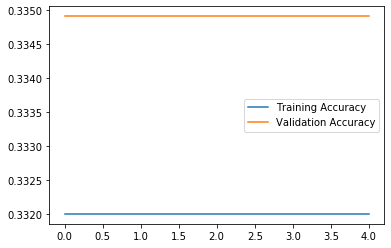

In [26]:
plt.plot(model.history['categorical_accuracy'])
plt.plot(model.history['val_categorical_accuracy'])
plt.legend(['Training Accuracy', 'Validation Accuracy'])

### Retraining with unfreezing - helps improve model

In [27]:
# Unfreeze the base model
base_model.trainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are taken into account
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate = .00001),  # Very low learning rate
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.CategoricalAccuracy()])

In [29]:
model2 = model.fit(img_iter,
          epochs=5,
          steps_per_epoch=len(X_train)/batch_size, # Run same number of steps we would if we were not using a generator.
          validation_data=(X_val, y_val))

Epoch 1/5
2131/2131 [==============================] - 293s 138ms/step - loss: 0.3940 - categorical_accuracy: 0.8519 - val_loss: 0.2188 - val_categorical_accuracy: 0.9279
Epoch 2/5
2131/2131 [==============================] - 292s 137ms/step - loss: 0.2722 - categorical_accuracy: 0.9024 - val_loss: 0.2408 - val_categorical_accuracy: 0.9279
Epoch 3/5
2131/2131 [==============================] - 281s 132ms/step - loss: 0.2519 - categorical_accuracy: 0.9142 - val_loss: 0.1992 - val_categorical_accuracy: 0.9250
Epoch 4/5
2131/2131 [==============================] - 287s 135ms/step - loss: 0.2585 - categorical_accuracy: 0.9157 - val_loss: 0.2900 - val_categorical_accuracy: 0.9099
Epoch 5/5
2131/2131 [==============================] - 286s 134ms/step - loss: 0.2617 - categorical_accuracy: 0.9167 - val_loss: 0.2134 - val_categorical_accuracy: 0.9355


In [30]:
model2.save('newtrainedVGG16_model_v2')

AttributeError: 'History' object has no attribute 'save'

Text(0, 0.5, 'Percent Loss')

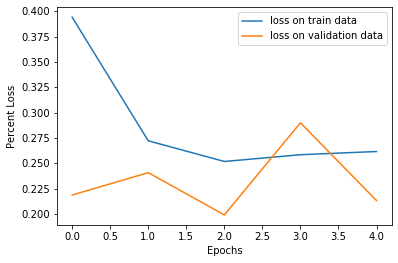

In [31]:
plt.plot(model2.history['loss'])
plt.plot(model2.history['val_loss'])
plt.legend(['loss on train data', 'loss on validation data'])
plt.xlabel('Epochs')
plt.ylabel('Percent Loss')

Text(0, 0.5, 'Percent Accuracy')

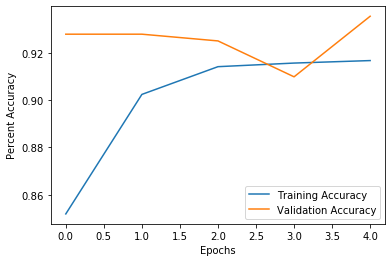

In [32]:
plt.plot(model2.history['categorical_accuracy'])
plt.plot(model2.history['val_categorical_accuracy'])
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Percent Accuracy')

### RESULTS!!!

In [55]:
model.evaluate(X_test, y_test)

34/34 [==============================] - 7s 215ms/step - loss: 0.2635 - categorical_accuracy: 0.9146


[0.26351115107536316, 0.9145539999008179]

In [20]:
y_pred = model.predict(X_test)

In [22]:
y_pred

array([[  0.99655426,  -1.3601578 ,  -0.1485035 ,  -2.296748  ],
       [ -6.0818596 ,   2.5486429 ,  -7.270322  ,   6.8674965 ],
       [ -1.8213096 ,   1.6545075 ,  -5.246475  ,   2.9209096 ],
       ...,
       [ -5.823853  ,  -2.089788  ,   7.802268  ,  -1.8393862 ],
       [  3.4895039 ,   3.326587  , -11.177018  ,  -5.44142   ],
       [  0.44868076,   3.3171978 ,  -7.892029  ,  -0.3603863 ]],
      dtype=float32)

In [26]:
y_pred.shape

(1065, 4)

In [28]:
np.save('y_pred_v1.npy', y_pred)

In [30]:
y_pred2 = y_pred
y_pred2

array([[  0.99655426,  -1.3601578 ,  -0.1485035 ,  -2.296748  ],
       [ -6.0818596 ,   2.5486429 ,  -7.270322  ,   6.8674965 ],
       [ -1.8213096 ,   1.6545075 ,  -5.246475  ,   2.9209096 ],
       ...,
       [ -5.823853  ,  -2.089788  ,   7.802268  ,  -1.8393862 ],
       [  3.4895039 ,   3.326587  , -11.177018  ,  -5.44142   ],
       [  0.44868076,   3.3171978 ,  -7.892029  ,  -0.3603863 ]],
      dtype=float32)

In [40]:
# to convert the y_pred to a onehot encoding equivalent
for i in range(1065):
    max_index = np.argmax(y_pred2[i], axis=0)
    for j in range(4):
        if j == max_index:
            y_pred2[i][j]=1
        else:
            y_pred2[i][j]=0


In [52]:
y_pred2.shape
y_test.shape
y_test

array([[1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]])

In [42]:
y_pred2

array([[1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]], dtype=float32)

### CONFUSION MATRIX 

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred2)
confusion_matrix

In [50]:
from sklearn.metrics import multilabel_confusion_matrix
conf_mat = multilabel_confusion_matrix(y_test, y_pred2)
conf_mat

array([[[812,  22],
        [ 28, 203]],

       [[753,  27],
        [ 61, 224]],

       [[673,  16],
        [  2, 374]],

       [[850,  42],
        [ 16, 157]]])

### ROC 

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.cluster import KMeans

# Loading Model

In [118]:
model = keras.models.load_model('newtrained2VGG16_model')

In [119]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 500, 500, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 15, 15, 512)       14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 4)                 2052      
Total params: 14,716,740
Trainable params: 14,716,740
Non-trainable params: 0
_________________________________________________________________


In [11]:
out = model.evaluate(X_test, y_test)

34/34 [==============================] - 23s 325ms/step - loss: 0.2635 - categorical_accuracy: 0.9146


In [1]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


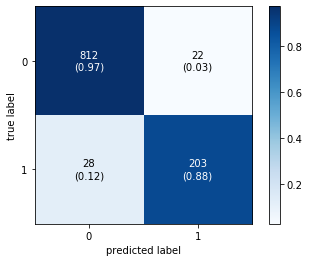

In [2]:
binary = np.array([[812, 22],
                   [28, 203]])

fig, ax = plot_confusion_matrix(conf_mat=binary,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

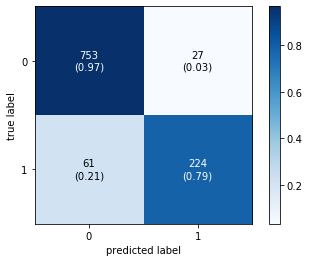

In [3]:
binary = np.array([[753,  27],[ 61, 224]])

fig, ax = plot_confusion_matrix(conf_mat=binary,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

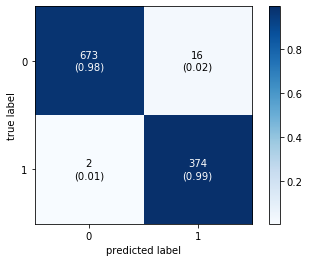

In [4]:
binary = np.array([[673,  16],[  2, 374]])

fig, ax = plot_confusion_matrix(conf_mat=binary,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

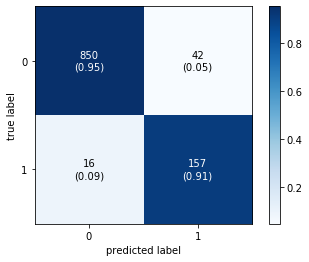

In [5]:
binary = np.array([[850,  42],
        [ 16, 157]])

fig, ax = plot_confusion_matrix(conf_mat=binary,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

# XAI METHOD

### tf-explain

In [51]:
filename = 'ECGDenoisedImages/MUSE_20180111_155115_19000.png'
image = cv2.imread(filename,1)
image2 = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY )
img2 = np.zeros_like(image)
img2[:,:,0] = image2
img2[:,:,1] = image2
img2[:,:,2] = image2

img2 = img2.astype(np.float32)
cv2.imwrite('XAI_test.jpg', img2)

print(img2.shape)
img2.dtype

(500, 500, 3)


dtype('float32')

In [56]:
# GRAD CAM --- works?


# Load a sample image (or multiple ones)
#img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(224, 224))
img = tf.keras.preprocessing.image.load_img('XAI_test.jpg', target_size=(500,500,3))
img_new = tf.keras.preprocessing.image.img_to_array(img)
#print(img_new.shape)

data = ([img_new], None)

#class_index0 = 
class_index0 = model.predict(data)

#data = (X_test[0:1])
print('data_type:',type(data))
#class_index0 = classlabel[1] 
#class_index0 = [0, 1, 0, 0]
#class_index0 = (1, None)
print(type(class_index0))


# Start explainer
explainer = GradCAM()
grid = explainer.explain(data, model, class_index=class_index0, layer_name="dense")  


explainer.save(grid, ".", "grad_cam4.png")

ValueError: Failed to find data adapter that can handle input: (<class 'tuple'> containing values of types {'(<class \'list\'> containing values of types {"<class \'numpy.ndarray\'>"})', "<class 'NoneType'>"}), <class 'NoneType'>

In [6]:
# OcclusionSensitivity --- works


img = tf.keras.preprocessing.image.load_img('XAI_test.jpg', target_size=(500,500,3))
img = tf.keras.preprocessing.image.img_to_array(img)
data = ([img], None)


# Start explainer
explainer = OcclusionSensitivity()
grid = explainer.explain(data, model,class_index=1, patch_size= 10)  # 281 is the tabby cat index in ImageNet

explainer.save(grid, ".", "OccSens2.png")

NotFoundError:  No algorithm worked!
	 [[node model/vgg16/block1_conv1/Relu (defined at /home/koolaid/.local/lib/python3.8/site-packages/tf_explain/core/occlusion_sensitivity.py:100) ]] [Op:__inference_predict_function_3728]

Function call stack:
predict_function


In [50]:
# SmoothGrad --- Works


img = tf.keras.preprocessing.image.load_img('temp_outputs/img0.png', target_size=(32,32,3))
img = tf.keras.preprocessing.image.img_to_array(img)
data = ([img], None)


# Start explainer
explainer = SmoothGrad()
grid = explainer.explain(data, resnet50_model,class_index=6, num_samples=100, noise =0)  # 281 is the tabby cat index in ImageNet

explainer.save(grid, ".", "SmoothGrad2.png")

In [51]:
# IntegratedGradients --- Works


img = tf.keras.preprocessing.image.load_img('temp_outputs/img0.png', target_size=(32,32,3))
img = tf.keras.preprocessing.image.img_to_array(img)
data = ([img], None)


# Start explainer
explainer = IntegratedGradients()
grid = explainer.explain(data, resnet50_model,class_index=6, n_steps=10)  # 281 is the tabby cat index in ImageNet

explainer.save(grid, ".", "IntGrad2.png")

In [ ]:
# VanillaGradients ---- ERROR


img = tf.keras.preprocessing.image.load_img('temp_outputs/img0.png', target_size=(32,32,3))
img = tf.keras.preprocessing.image.img_to_array(img)
data = ([img], None)


# Start explainer
explainer = VanillaGradients()
grid = explainer.explain(data, resnet50_model, class_index=6)  # 281 is the tabby cat index in ImageNet

explainer.save(grid, ".", "VanGrad.png")

In [ ]:
# Extract Activations ---- ERROR in padding


img = tf.keras.preprocessing.image.load_img('temp_outputs/img0.png', target_size=(32,32,3))
img = tf.keras.preprocessing.image.img_to_array(img)
data = ([img], None)


# Start explainer
explainer = ExtractActivations()
grid = explainer.explain(data, resnet50_model, ('activation_48'))  # 281 is the tabby cat index in ImageNet

explainer.save(grid, ".", "extactAct.png")

In [51]:
# Load a sample image (or multiple ones)
#img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(224, 224))
img = tf.keras.preprocessing.image.load_img('temp_outputs/img0.png', target_size=(32,32,3))
img = tf.keras.preprocessing.image.img_to_array(img)
data = ([img], None)


# Start explainer
explainer = GradCAM()
grid = explainer.explain(data, resnet50_model, class_index=6)  # 6 is the frog index 

explainer.save(grid, ".", "grad_cam.png")

In [117]:
image = X_val[3].mean(axis = 2).astype(np.float32)

In [118]:
image.shape

(500, 500)

In [119]:
# Import explainer
from tf_explain.core.grad_cam import GradCAM



# Instantiation of the explainer
explainer = GradCAM()


# Call to explain() method
output = explainer.explain(image, model, 1)

output_dir = "/temp_outputs"
os.makedirs(output_dir, exist_ok=True)
output_name = first

# Save output
explainer.save(output, output_dir, output_name)

ValueError: too many values to unpack (expected 2)

In [8]:
import datetime
from tensorflow.keras.callbacks import TensorBoard

%load_ext tensorboard

In [ ]:
from tf_explain.callbacks.grad_cam import GradCAMCallback


model = model

output_dir = "temp_outputs/"
os.makedirs(output_dir, exist_ok=True)

callbacks = [
    GradCAMCallback(
        validation_data=(X_val, y_val),
        #layer_name="global_average_pooling2d",
        layer_name = None,
        class_index=0,
        output_dir=output_dir,
    )
]


logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#callbacks = tf.keras.callbacks.TensorBoard(logdir,profile_batch=0,update_freq='epoch',histogram_freq=1)

model.fit(X_train, y_train, batch_size=2, epochs=2, callbacks=callbacks)

In [16]:
%%js
var url = window.location.hostname + ':6006';
element.append(url)

<IPython.core.display.Javascript object>

In [17]:
%tensorboard --logdir logs

### Guided Grad-Cam

##### https://github.com/insikk/Grad-CAM-tensorflow/blob/master/gradCAM_tensorflow_VGG16_demo.ipynb

### Saliency Maps

##### https://github.com/usmanr149/Saliency-Maps-in-TF-2.0/blob/master/Saliency%20Map%20in%20Tensorflow%202.0.ipynb

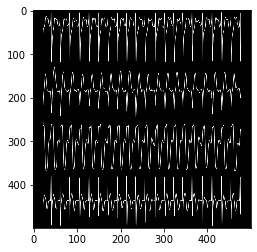

In [12]:
_img = keras.preprocessing.image.load_img('XAI_test.jpg',target_size=(500,500,3))
plt.imshow(_img)
plt.show()

In [13]:
#preprocess image to get it into the right format for the model
img = keras.preprocessing.image.img_to_array(_img)
img = img.reshape((1, *img.shape))
y_pred = model.predict(img)

In [14]:
y_pred

array([[ 1.103594 ,  2.1204515, -6.2607136, -3.5747418]], dtype=float32)

In [15]:
layers = [layer.output for layer in model.layers]

In [16]:
layers

[<KerasTensor: shape=(None, 500, 500, 3) dtype=float32 (created by layer 'input_2')>,
 <KerasTensor: shape=(None, 15, 15, 512) dtype=float32 (created by layer 'block5_pool')>,
 <KerasTensor: shape=(None, 512) dtype=float32 (created by layer 'global_average_pooling2d')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'dense')>]

In [17]:
images = tf.Variable(img, dtype=float)

with tf.GradientTape() as tape:
    pred = model(images, training=False)
    class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]
    loss = pred[0][class_idxs_sorted[0]]
    
grads = tape.gradient(loss, images)

In [23]:
grads

<tf.Tensor: shape=(1, 500, 500, 3), dtype=float32, numpy=
array([[[[ 6.15733029e-08,  1.36831238e-06,  3.95770201e-07],
         [ 1.09289417e-07,  2.13992826e-06,  7.68595498e-07],
         [-5.63731874e-07,  1.62707533e-06,  5.76249249e-07],
         ...,
         [ 1.38921806e-07,  4.11592325e-08, -2.35891264e-07],
         [ 1.23807197e-07, -7.22715185e-08, -1.02543616e-07],
         [ 3.00233296e-08, -1.29742105e-07, -4.10761061e-08]],

        [[ 1.04928370e-06,  3.61613593e-06,  2.05018682e-06],
         [ 1.74526940e-06,  5.61139768e-06,  3.54845270e-06],
         [ 5.97960366e-08,  4.01871011e-06,  2.82824885e-06],
         ...,
         [ 4.04328176e-07,  2.99411141e-07, -2.97196493e-07],
         [ 5.02683577e-07,  2.90722085e-07,  1.17935969e-07],
         [ 2.87958073e-07,  1.00900621e-07,  1.88688446e-07]],

        [[ 7.37339803e-07,  3.57500085e-06,  2.50287985e-06],
         [ 5.21588390e-07,  4.59987177e-06,  3.71407918e-06],
         [-2.49888171e-06,  1.17865193e-06

In [24]:
grads.shape

TensorShape([1, 500, 500, 3])

In [25]:
dgrad_abs = tf.math.abs(grads)

In [108]:
dgrad_max_ = np.max(dgrad_abs, axis=3)[0]

In [109]:
dgrad_max_.shape

(500, 500)

In [110]:
## normalize to range between 0 and 1
arr_min, arr_max  = np.min(dgrad_max_), np.max(dgrad_max_)
grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)

In [111]:
grad_eval.shape

(500, 500)

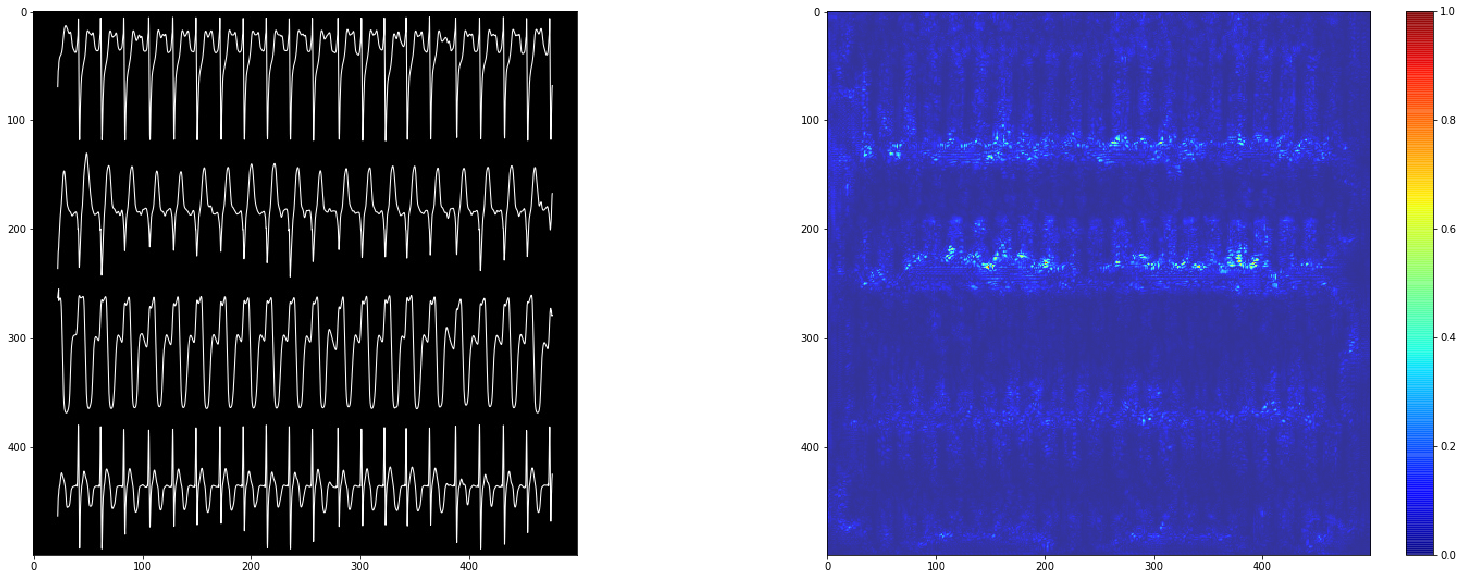

In [112]:
fig, axes = plt.subplots(1,2,figsize=(28,10))
axes[0].imshow(_img)
i = axes[1].imshow(grad_eval,cmap="jet",alpha=0.8)
fig.colorbar(i)

### GRAD-CAM

##### https://fairyonice.github.io/Grad-CAM-with-keras-vis.html

##### also see... https://fairyonice.github.io/Saliency-Map-with-keras-vis.html

In [33]:
import vis ## keras-vis

In [78]:
model = keras.models.load_model('pretrainedVGG16_model')

In [80]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 500, 500, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 15, 15, 512)       14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 4)                 2052      
Total params: 14,716,740
Trainable params: 14,716,740
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.summary()
for ilayer, layer in enumerate(model.layers):
    print("{:3.0f} {:10}".format(ilayer, layer.name))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 500, 500, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 15, 15, 512)       14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 4)                 2052      
Total params: 14,716,740
Trainable params: 14,716,740
Non-trainable params: 0
_________________________________________________________________
  0 input_2   
  1 vgg16     
  2 global_average_pooling2d
  3 dense     


In [63]:
model.layers

#### HOLD OFF ON THESE BLOCKS

In [ ]:
!wget "https://raw.githubusercontent.com/raghakot/keras-vis/master/resources/imagenet_class_index.json"

In [ ]:
import json
CLASS_INDEX = json.load(open("imagenet_class_index.json"))
classlabel  = []
for i_dict in range(len(CLASS_INDEX)):
    classlabel.append(CLASS_INDEX[str(i_dict)][1])
print("N of class={}".format(len(classlabel)))

In [39]:
classlabel = ['AFIB', 'GSVT', 'SB', 'SR']
classlabel

['AFIB', 'GSVT', 'SB', 'SR']

#### RESUME FROM HERE

Using TensorFlow backend.


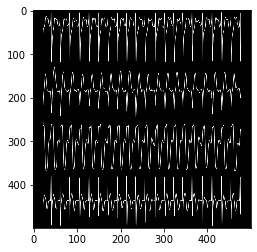

In [35]:
from keras.preprocessing.image import load_img, img_to_array
#_img = load_img("duck.jpg",target_size=(224,224))
_img = load_img("XAI_test.jpg",target_size=(500,500,3))
plt.imshow(_img)
plt.show()

In [40]:
img               = img_to_array(_img)
#img               = preprocess_input(img)
y_pred            = model.predict(img[np.newaxis,...])
class_idxs_sorted = np.argsort(y_pred.flatten())[::-1]
topNclass         = 5
for i, idx in enumerate(class_idxs_sorted[:topNclass]):
    print("Top {} predicted class:     Pr(Class={:18} [index={}])={:5.3f}".format(
          i + 1,classlabel[idx],idx,y_pred[0,idx]))

Top 1 predicted class:     Pr(Class=GSVT               [index=1])=2.120
Top 2 predicted class:     Pr(Class=AFIB               [index=0])=1.104
Top 3 predicted class:     Pr(Class=SR                 [index=3])=-3.575
Top 4 predicted class:     Pr(Class=SB                 [index=2])=-6.261


In [77]:
from vis.utils import utils
# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model,'dense')
# Swap softmax with linear
model.layers[layer_idx].activation = keras.activations.linear
model = utils.apply_modifications(model)

ValueError: Unknown layer: Functional

In [ ]:
from vis.visualization import visualize_cam
penultimate_layer_idx = utils.find_layer_idx(model, "block5_conv3") 
class_idx  = class_idxs_sorted[0]
seed_input = img
grad_top1  = visualize_cam(model, layer_idx, class_idx, seed_input, 
                           penultimate_layer_idx = penultimate_layer_idx,#None,
                           backprop_modifier     = None,
                           grad_modifier         = None)

In [ ]:
def plot_map(grads):
    fig, axes = plt.subplots(1,2,figsize=(14,5))
    axes[0].imshow(_img)
    axes[1].imshow(_img)
    i = axes[1].imshow(grads,cmap="jet",alpha=0.8)
    fig.colorbar(i)
    plt.suptitle("Pr(class={}) = {:5.2f}".format(
                      classlabel[class_idx],
                      y_pred[0,class_idx]))
plot_map(grad_top1)

In [ ]:
for class_idx in class_idxs_sorted[:topNclass]:
    grads  = visualize_cam(model,layer_idx,class_idx, seed_input,
                           penultimate_layer_idx = penultimate_layer_idx,
                           backprop_modifier     = None,
                           grad_modifier         = None)
    plot_map(grads)

### Grad-cam v2

##### https://gist.github.com/RaphaelMeudec/e9a805fa82880876f8d89766f0690b54

In [73]:
import cv2
import numpy as np
import tensorflow as tf

IMAGE_PATH = 'XAI_test.jpg'
LAYER_NAME = 'dense'
CAT_CLASS_INDEX = 1

img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(500, 500, 3))
img = tf.keras.preprocessing.image.img_to_array(img)

#model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=True)

grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(LAYER_NAME).output, model.output])

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(np.array([img]))
    loss = predictions[:, CAT_CLASS_INDEX]

output = conv_outputs[0]
grads = tape.gradient(loss, conv_outputs)[0]

gate_f = tf.cast(output > 0, 'float32')
gate_r = tf.cast(grads > 0, 'float32')
guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

weights = tf.reduce_mean(guided_grads, axis=(0))

cam = np.ones(output.shape[0: 2], dtype = np.float32)

for i, w in enumerate(weights):
    cam += w * output[:, :, i]

cam = cv2.resize(cam.numpy(), (224, 224))
cam = np.maximum(cam, 0)
heatmap = (cam - cam.min()) / (cam.max() - cam.min())

cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

output_image = cv2.addWeighted(cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR), 0.5, cam, 1, 0)

cv2.imwrite('cam.png', output_image)

TypeError: Cannot iterate over a scalar tensor.

### Grad-cam v3.

##### https://pythonawesome.com/the-fastest-way-to-visualize-gradcam-in-keras-models/

In [74]:
import cv2
import numpy as np
from PIL import Image
import tensorflow as tf
import tensorflow.keras as K
import matplotlib.pyplot as plt
from skimage.transform import resize
from tensorflow.keras.models import Model


def VizGradCAM(model, image, interpolant=0.5, plot_results=True):
    """VizGradCAM - Displays GradCAM based on Keras / TensorFlow models
    using the gradients from the last convolutional layer. This function
    should work with all Keras Application listed here:
    https://keras.io/api/applications/
    Parameters:
    model (keras.model): Compiled Model with Weights Loaded
    image: Image to Perform Inference On
    plot_results (boolean): True - Function Plots using PLT
                            False - Returns Heatmap Array
    Returns:
    Heatmap Array?
    """
    # Sanity Check
    assert (
        interpolant > 0 and interpolant < 1
    ), "Heatmap Interpolation Must Be Between 0 - 1"

    last_conv_layer = next(
        x for x in model.layers[::-1] if isinstance(x, K.layers.Conv2D)
    )
    target_layer = model.get_layer(last_conv_layer.name)

    original_img = image
    img = np.expand_dims(original_img, axis=0)
    prediction = model.predict(img)

    # Obtain Prediction Index
    prediction_idx = np.argmax(prediction)

    # Compute Gradient of Top Predicted Class
    with tf.GradientTape() as tape:
        gradient_model = Model([model.inputs], [target_layer.output, model.output])
        conv2d_out, prediction = gradient_model(img)
        # Obtain the Prediction Loss
        loss = prediction[:, prediction_idx]

    # Gradient() computes the gradient using operations recorded
    # in context of this tape
    gradients = tape.gradient(loss, conv2d_out)

    # Obtain the Output from Shape [1 x H x W x CHANNEL] -> [H x W x CHANNEL]
    output = conv2d_out[0]

    # Obtain Depthwise Mean
    weights = tf.reduce_mean(gradients[0], axis=(0, 1))

    # Create a 7x7 Map for Aggregation
    activation_map = np.zeros(output.shape[0:2], dtype=np.float32)

    # Multiply Weights with Every Layer
    for idx, weight in enumerate(weights):
        activation_map += weight * output[:, :, idx]

    # Resize to Size of Image
    activation_map = cv2.resize(
        activation_map.numpy(), (original_img.shape[1], original_img.shape[0])
    )

    # Ensure No Negative Numbers
    activation_map = np.maximum(activation_map, 0)

    # Convert Class Activation Map to 0 - 255
    activation_map = (activation_map - activation_map.min()) / (
        activation_map.max() - activation_map.min()
    )
    activation_map = np.uint8(255 * activation_map)

    # Convert to Heatmap
    heatmap = cv2.applyColorMap(activation_map, cv2.COLORMAP_JET)

    # Superimpose Heatmap on Image Data
    original_img = np.uint8(
        (original_img - original_img.min())
        / (original_img.max() - original_img.min())
        * 255
    )

    cvt_heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Enlarge Plot
    plt.rcParams["figure.dpi"] = 100

    if plot_results == True:
        plt.imshow(
            np.uint8(original_img * interpolant + cvt_heatmap * (1 - interpolant))
        )
    else:
        return cvt_heatmap


In [76]:
# Load Your Favourite Image
test_img = img_to_array(load_img("XAI_test.jpg" , target_size=(500,500,3)))

# Use The Function - Boom!
VizGradCAM(model, test_img)

StopIteration: 

### Smooth Cam 

##### https://github.com/tabayashi0117/Score-CAM/blob/master/Score-CAM.ipynb

# Testing with alternate files

In [114]:
filename = 'ECGDenoisedImages/MUSE_20180111_155154_74000.png'
image = cv2.imread(filename,1)
image2 = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY )
img2 = np.zeros_like(image)
img2[:,:,0] = image2
img2[:,:,1] = image2
img2[:,:,2] = image2

img2 = img2.astype(np.float32)
cv2.imwrite('XAI_test_2.jpg', img2)

print(img2.shape)shareefa vs chikoo
img2.dtype

(500, 500, 3)


dtype('float32')

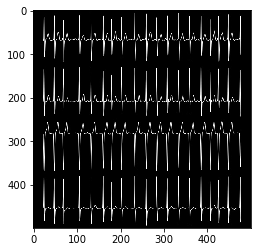

In [120]:
_img = keras.preprocessing.image.load_img('XAI_test_2.jpg',target_size=(500,500,3))
plt.imshow(_img)
plt.show()

In [121]:
#preprocess image to get it into the right format for the model
img = keras.preprocessing.image.img_to_array(_img)
img = img.reshape((1, *img.shape))
y_pred = model.predict(img)

In [122]:
y_pred

array([[ 3.6288521,  0.96808  , -8.311557 , -4.835578 ]], dtype=float32)

In [123]:
layers = [layer.output for layer in model.layers]

In [124]:
layers

[<KerasTensor: shape=(None, 500, 500, 3) dtype=float32 (created by layer 'input_2')>,
 <KerasTensor: shape=(None, 15, 15, 512) dtype=float32 (created by layer 'block5_pool')>,
 <KerasTensor: shape=(None, 512) dtype=float32 (created by layer 'global_average_pooling2d')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'dense')>]

In [125]:
images = tf.Variable(img, dtype=float)

with tf.GradientTape() as tape:
    pred = model(images, training=False)
    class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]
    loss = pred[0][class_idxs_sorted[0]]
    
grads = tape.gradient(loss, images)

In [126]:
grads

<tf.Tensor: shape=(1, 500, 500, 3), dtype=float32, numpy=
array([[[[ 1.19524046e-07, -8.64345907e-07, -1.06830171e-07],
         [ 1.37100784e-08, -1.50394919e-06, -1.31739625e-07],
         [-9.45743324e-08, -1.82708823e-06, -7.16955597e-08],
         ...,
         [ 7.60664349e-08,  3.10089746e-07,  3.29393600e-07],
         [ 2.86603985e-08,  1.00401493e-07,  1.76927486e-07],
         [-2.17800764e-08, -7.61905028e-08,  1.24199824e-08]],

        [[-3.03209674e-07, -1.81833843e-06, -2.83831440e-07],
         [-3.61417278e-07, -2.46400737e-06,  2.78146189e-07],
         [ 3.32316290e-08, -2.08269421e-06,  1.38717451e-06],
         ...,
         [ 4.62561559e-07,  9.04672788e-07,  9.16523618e-07],
         [ 3.50810524e-07,  5.54020062e-07,  6.53039024e-07],
         [ 1.07364876e-07,  4.90973306e-08,  1.88617079e-07]],

        [[-9.92592675e-08, -1.45814693e-06,  1.18826688e-06],
         [ 4.47784544e-07, -1.18602020e-06,  3.63387539e-06],
         [ 2.76223432e-07, -1.06814900e-06

In [127]:
grads.shape

TensorShape([1, 500, 500, 3])

In [128]:
dgrad_abs = tf.math.abs(grads)

In [129]:
dgrad_max_ = np.max(dgrad_abs, axis=3)[0]

In [130]:
dgrad_max_.shape

(500, 500)

In [131]:
## normalize to range between 0 and 1
arr_min, arr_max  = np.min(dgrad_max_), np.max(dgrad_max_)
grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)

In [132]:
grad_eval.shape

(500, 500)

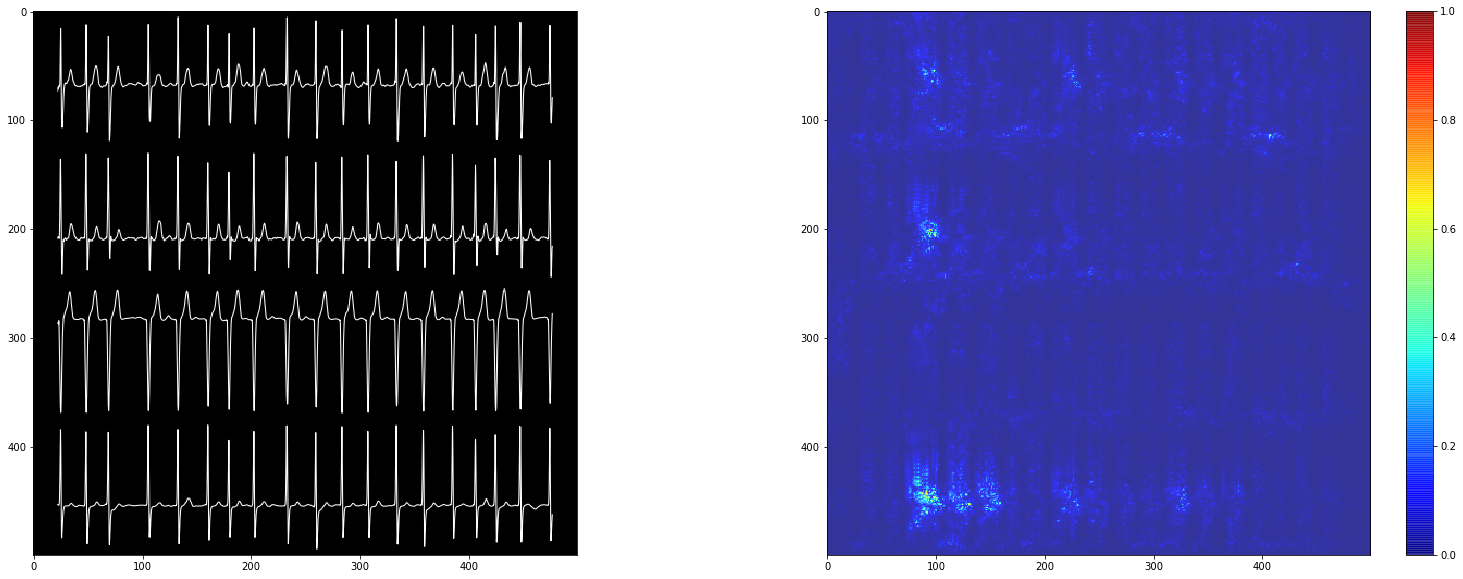

In [133]:
fig, axes = plt.subplots(1,2,figsize=(28,10))
axes[0].imshow(_img)
i = axes[1].imshow(grad_eval,cmap="jet",alpha=0.8)
fig.colorbar(i)